# Use PVLIB to convert Himwari irradiance to PV output

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pvlib
import numpy as np
from datetime import datetime, timedelta
import cartopy.crs as ccrs
import os
from pathlib import Path

import sys

import xarray as xr

ERROR 1: PROJ: proj_create_from_database: Open of /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/share/proj failed


In [2]:
# get the module and inverter specifications from SAM
sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
sapm_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')
module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']

In [3]:
S7 = (-30.6, 136.9)
Q2 = (-19.0, 144.0)
N3 = (-32.0, 148.8)
Q8 = (-27.6, 151.4)

def solar_bias(date, coords):
    # sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
    # sapm_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')
    # module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
    # inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']
    
    day = date[0:2]
    month = date[2:4]
    year = date[4:8]
    directory=Path(f'/g/data/rv74/satellite-products/arc/der/himawari-ahi/solar/p1s/v1.1/{year}/{month}/{day}')
    files = sorted(str(p) for p in directory.rglob("*.nc"))
    def _preprocess(ds):
        return ds.drop_vars(set(ds.data_vars) - {'surface_global_irradiance', 'direct_normal_irradiance', 'surface_diffuse_irradiance'}).sel(
            latitude=coords[0],
            longitude=coords[1],
            method='nearest'
        )
    
    ds = xr.open_mfdataset(
        files,
        combine='by_coords',
        preprocess=_preprocess,
        engine='h5netcdf',
        chunks={}
    )
    
    # get variables for solar pv model calculations
    
    time = ds.time.values
    lat = ds.latitude.values
    lon = ds.longitude.values
    # Compute solar position for all grid cells at once
    solpos = pvlib.solarposition.get_solarposition(
        time,
        lat,
        lon
    )
    # find the angle of incidence of the sun on the panel for a single-axis tracking system
    airmass_relative = pvlib.atmosphere.get_relative_airmass(
        solpos['apparent_zenith'].values
    )
    airmass_absolute = pvlib.atmosphere.get_absolute_airmass(
        airmass_relative,
    )
    
    # function for linke turbidity does not work for array of data, currently using approximation instead
    # Approximation of linke_turbidity for clearsky irradiance calculations
    linke_turbidity = np.maximum(2 + 0.1 * airmass_absolute, 2.5)
    # linke_turbidity = pvlib.clearsky.lookup_linke_turbidity(
    #     time=pd.to_datetime(time),
    #     latitude=lat,
    #     longitude=lon,
    #     interp_turbidity=True
    # )
    doy = pd.to_datetime(time).dayofyear
    dni_extra = pvlib.irradiance.get_extra_radiation(doy)
    ineichen = pvlib.clearsky.ineichen(
        apparent_zenith=solpos['apparent_zenith'].values,
        airmass_absolute=airmass_absolute,
        linke_turbidity=linke_turbidity,
        dni_extra=dni_extra
    )
    simplified_solis = pvlib.clearsky.simplified_solis(
        apparent_elevation=solpos['apparent_elevation'],
        dni_extra=dni_extra
    )
    
    # Output irradiances
    ghi_himawari = ds.surface_global_irradiance.values
    ghi_ineichen = ineichen['ghi']
    ghi_ss = simplified_solis['ghi'].values
    return ghi_himawari, ghi_ineichen, ghi_ss

# Compare ideal vs observation

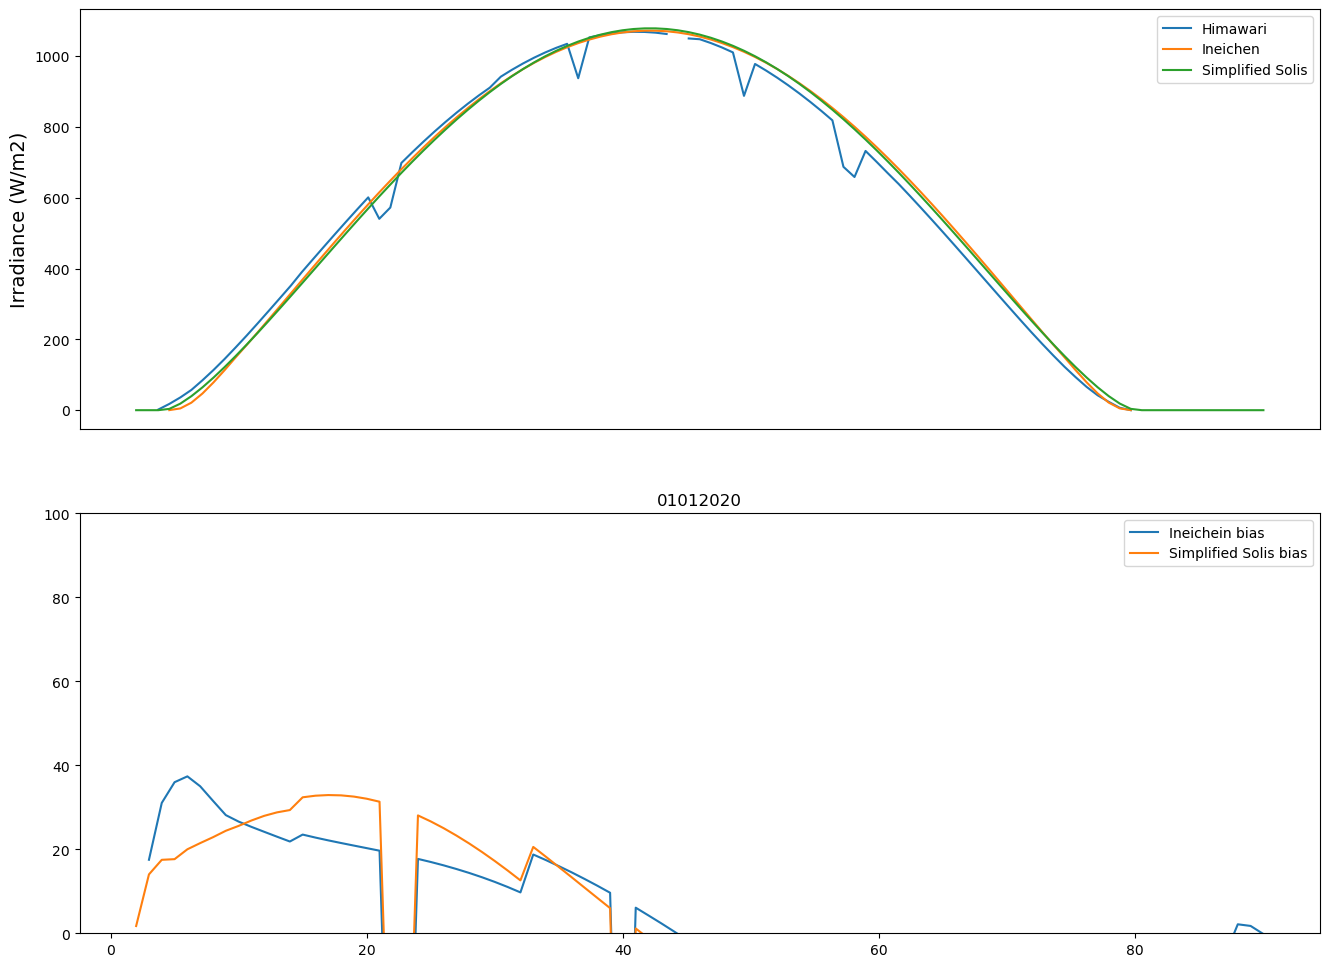

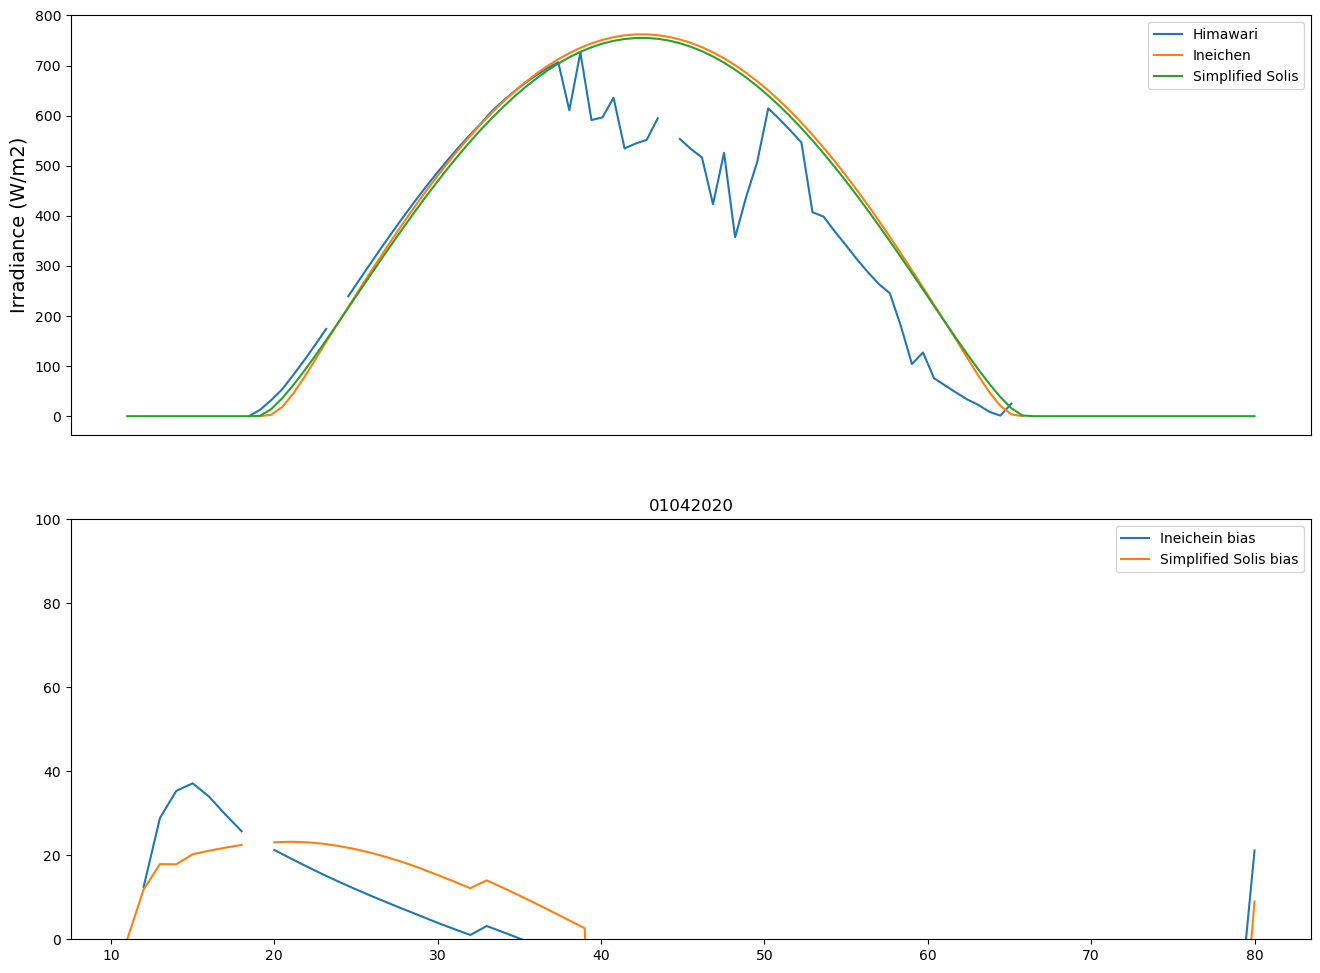

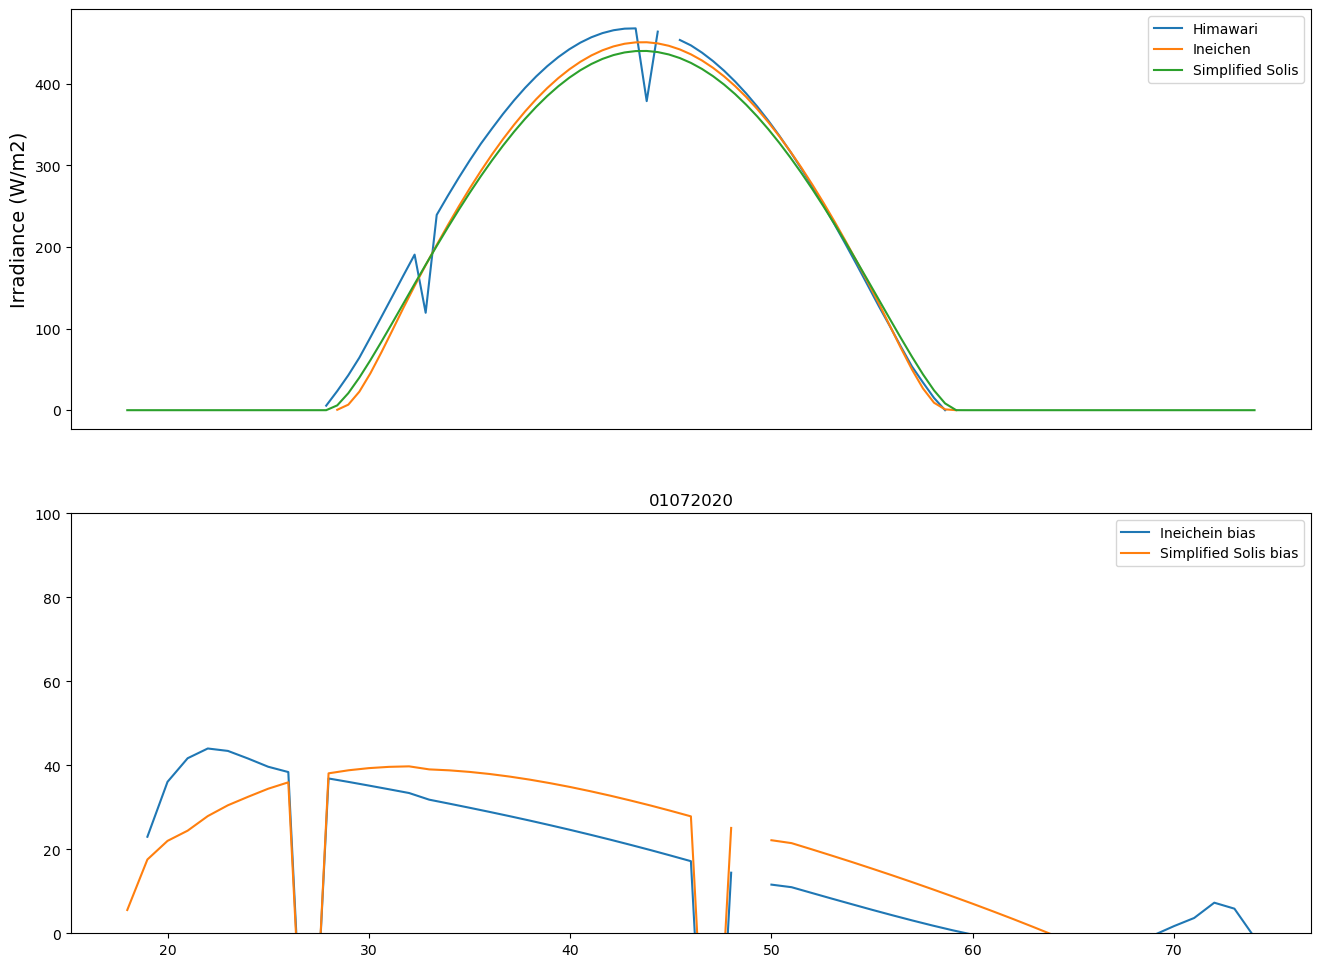

OSError: no files to open

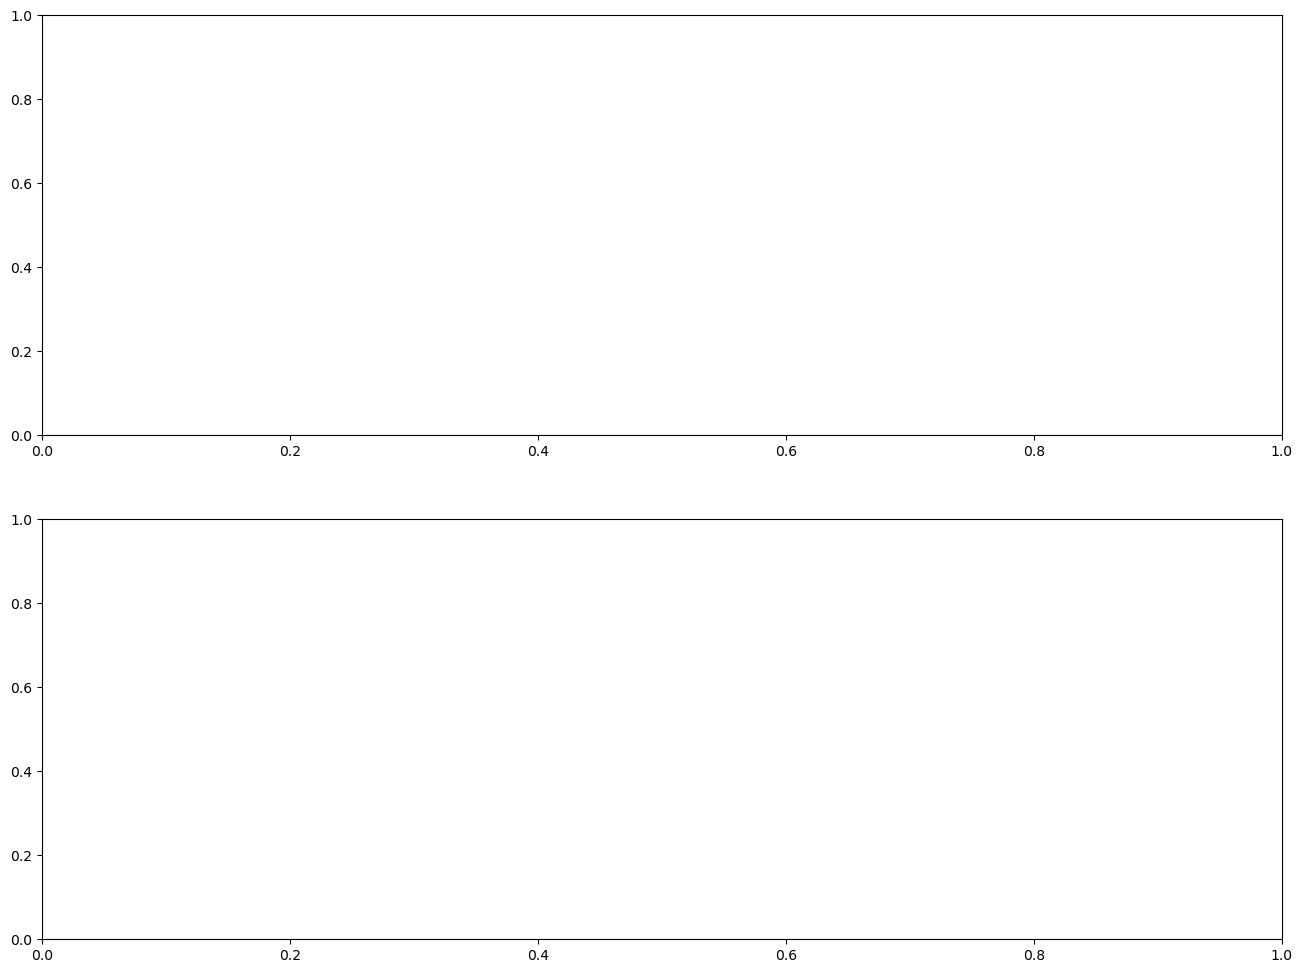

In [34]:
S7 = (-30.6, 136.9)
Q2 = (-19.0, 144.0)
N3 = (-32.0, 148.8)
Q8 = (-27.6, 151.4)
V5 = (-38.2, 147.0)
dates = [
    '01012020',
    '01042020',
    '01072020',
    '010102020'
]
for date in dates:
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16,12))
    ghi_himawari, ghi_ineichen, ghi_ss = solar_bias(date=date, coords=V5)
    ax[0].plot(ghi_himawari, label='Himawari')
    ax[0].plot(ghi_ineichen, label='Ineichen')
    ax[0].plot(ghi_ss, label='Simplified Solis')
    ax[0].legend()
    ax[0].set_ylabel('Irradiance (W/m2)', fontsize = 14)
    ax[0].set_xticks([])
    plt.title(f'{date}')
    
    ax[1].plot(ghi_himawari - ghi_ineichen, label='Ineichein bias')
    ax[1].plot(ghi_himawari - ghi_ss, label='Simplified Solis bias')
    ax[1].set_ylim(0., 100)
    ax[1].legend()
    
    plt.show()

In [25]:
date = '12082019'
day = date[0:2]
month = date[2:4]
year = date[4:8]

S7 = (-30.6, 136.9)
Q2 = (-19.0, 144.0)
N3 = (-32.0, 148.8)
Q8 = (-27.6, 151.4)
V5 = (-38.2, 147.0)

coords=S7

directory=Path(f'/g/data/rv74/satellite-products/arc/der/himawari-ahi/solar/p1s/v1.1/{year}/{month}/{day}')
files = sorted(str(p) for p in directory.rglob("*.nc"))
def _preprocess(ds):
    return ds.drop_vars(set(ds.data_vars) - {'surface_global_irradiance', 'direct_normal_irradiance', 'surface_diffuse_irradiance'}).sel(
        latitude=coords[0],
        longitude=coords[1],
        method='nearest'
    )

ds = xr.open_mfdataset(
    files,
    combine='by_coords',
    preprocess=_preprocess,
    engine='h5netcdf',
    chunks={}
)

2019-08-12T00:00:00.000000000
2019-08-12T05:50:00.000000000


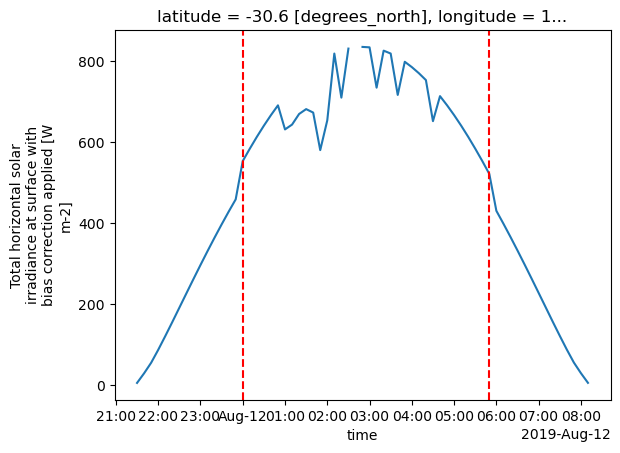

In [32]:
ds.surface_global_irradiance.plot()
start = ds.isel(time=33).time.values
end = ds.isel(time=68).time.values
plt.axvline(start, color='r', linestyle='--')
plt.axvline(end, color='r', linestyle='--')
print(start)
print(end)